In [1794]:
# %pip install torch numpy ase torch_geometric scikit-learn pandas rdkit matplotlib imbalanced-learn seaborn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1795]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ase import Atoms
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
# from torch_geometric.data import DataLoader, TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from ase.build import molecule
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from torch_geometric.nn import global_add_pool, GATConv, CGConv, GCNConv, RGCNConv
from torch_geometric.nn.models.schnet import GaussianSmearing
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import seaborn as sns
import time
from torch.optim.lr_scheduler import StepLR
import copy

In [1796]:
with open('data/bio_data_rcgn.pkl', 'rb') as file:
    bio_data = pickle.load(file)

In [1797]:
data = bio_data[0]
print(len(bio_data))

2231


In [1798]:
# 0 is non-biodegradable, 1 is biodegradable
with open('data/bio_labels_rcgn.pkl', 'rb') as file:
    bio_labels = pickle.load(file)

In [1799]:
X_train, X_test, y_train, y_test = train_test_split(bio_data, bio_labels, test_size=0.2, random_state=49)

In [1800]:
# 0 is non-biodegradable, 1 is biodegradable
class_counts = Counter(y_train)
print(class_counts)

Counter({0: 1196, 1: 588})


In [1801]:
class_data = {}
for data, label in zip(X_train, y_train):
    if label not in class_data:
        class_data[label] = []
    class_data[label].append(data)

minority_class = min(class_counts, key=class_counts.get)
majority_class = max(class_counts, key=class_counts.get)

oversampled_data = class_data[minority_class].copy()
num_samples_to_add = int((class_counts[majority_class] - class_counts[minority_class]) * (1.0))
oversampled_data += class_data[minority_class][:num_samples_to_add]
balanced_data = oversampled_data + class_data[majority_class]
balanced_labels = [minority_class] * len(oversampled_data) + [majority_class] * len(class_data[majority_class])

combined_data = list(zip(balanced_data, balanced_labels))
random.shuffle(combined_data)
balanced_data, balanced_labels = zip(*combined_data)

balanced_X_train = list(balanced_data)
balanced_y_train = list(balanced_labels)

class_counts = Counter(balanced_y_train)
print(class_counts)

Counter({0: 1196, 1: 1176})


In [1802]:
batch_size = 32

print(balanced_X_train[0])
print(balanced_y_train[0])

train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Data(x=[17, 10], edge_index=[2, 16], edge_attr=[16], atom_data=[17, 35])
1


In [1803]:
NUM_ATOMS = 63
ATOM_DIM = 11
BOND_DIM = 5
LATENT_DIM = 256
HIDDEN_CHANNELS = 128
NUM_RELATION_TYPES = BOND_DIM - 1
NODE_FEATURE_DIM = ATOM_DIM - 1
BATCH_SIZE = 512
NUM_EPOCHS = 300

In [1804]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, num_relations):
        super(GraphEncoder, self).__init__()
        self.rgcnconv1 = RGCNConv(input_dim, 512, num_relations=num_relations)
        self.rgcnconv2 = RGCNConv(512, 256, num_relations=num_relations)
        self.rgcnconv3 = RGCNConv(256, 128, num_relations=num_relations)

    def forward(self, x, edge_index, edge_attr):
        x = self.rgcnconv1(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        x = self.rgcnconv2(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        # x = self.rgcnconv3(x, edge_index, edge_attr)
        # x = nn.ReLU()(x)
        return x

class BioClassifier(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(BioClassifier, self).__init__()
        
        self.encoder = GraphEncoder(input_dim, num_heads)
        self.fc1 = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = x.float()

        x = self.encoder(x, edge_index, edge_attr)
        x = global_add_pool(x, data.batch)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

In [1805]:
# Initialize model
model = BioClassifier(NODE_FEATURE_DIM, 4)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, gamma=0.9, step_size=10)

In [1806]:
# Train model
num_epochs = 400
train_losses, val_losses = [], []

# for early stopping
best_val_loss = float('inf')
patience = 15  # Number of epochs to wait if validation loss doesn't improve
counter = 0  # Counter for early stopping
early_stopping = False

best_model, best_epoch, best_precision = None, 0, 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        graph, bio = batch[0], batch[1]
        output = model(graph)
        loss = criterion(output.to(torch.float), bio.to(torch.float))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            graph, bio = batch[0], batch[1]
            output = model(graph)
            loss = criterion(output.to(torch.float), bio.to(torch.float))
            
            predicted = torch.round(output).int()
            bio = bio.int()
            
            val_loss += loss.item()
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    # old_lr = optimizer.param_groups[0]['lr']
    # scheduler.step()
    # new_lr = optimizer.param_groups[0]['lr']
    # if old_lr != new_lr:
    #     print(f'Learning rate reduced from {old_lr} to {new_lr}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_epoch = epoch
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    # Early stopping
    if early_stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

if best_model == None:
    best_model = model
print(f'Best Epoch: {best_epoch}, Best Val loss: {best_val_loss}')

Epoch 1/400, Train Loss: 0.02175766420605613, Val Loss: 0.020496877647886342
Epoch 2/400, Train Loss: 0.02020644131438527, Val Loss: 0.01996820058331927
Epoch 3/400, Train Loss: 0.019304692632130787, Val Loss: 0.019096736273242855
Epoch 4/400, Train Loss: 0.019012484178072688, Val Loss: 0.01822220932450604
Epoch 5/400, Train Loss: 0.01880796341630701, Val Loss: 0.01838241034172792
Epoch 6/400, Train Loss: 0.018569179117981137, Val Loss: 0.01744264157559781
Epoch 7/400, Train Loss: 0.01849772759774483, Val Loss: 0.01744792578737741
Epoch 8/400, Train Loss: 0.01778469940813959, Val Loss: 0.017389416761312976
Epoch 9/400, Train Loss: 0.017655426293963324, Val Loss: 0.016934025941012423
Epoch 10/400, Train Loss: 0.018123583375000432, Val Loss: 0.01679899235166426
Epoch 11/400, Train Loss: 0.01753623330020181, Val Loss: 0.016599735424289233
Epoch 12/400, Train Loss: 0.01734224905402825, Val Loss: 0.01699772930518626
Epoch 13/400, Train Loss: 0.017133377706019512, Val Loss: 0.016182749263392

In [1807]:
print(f'Best Epoch: {best_epoch}, Best Val loss: {best_val_loss}')
# Evaluate model
best_model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    TP, FP, TN, FN = 0, 0, 0, 0
    for batch in test_dataset:
        graph, label = batch[0], batch[1]
        output = best_model(graph)
        predicted = torch.round(output)
        total += 1
        y_true.append(int(label))
        y_pred.append(predicted)
        if predicted == int(label):
            correct += 1
        if predicted == 1:
            if int(label) == 1:
                TP += 1
            else:
                FP += 1
        if predicted == 0:
            if int(label) == 1:
                FN += 1
            else:
                TN += 1

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    Ba = (Sn + Sp) / 2
    print(f'Balanced Accuracy: {Ba}')

Best Epoch: 294, Best Val loss: 0.011840925687378151
Accuracy: 0.825503355704698
Balanced Accuracy: 0.834548557244803


ROC AUC Score: 0.834548557244803
Precision:  0.7


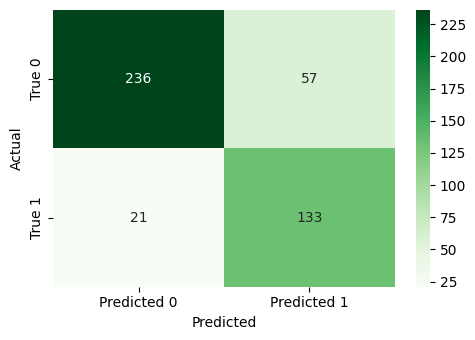

In [1808]:
auc_roc = roc_auc_score(y_true, y_pred)
print("ROC AUC Score:", auc_roc)
precision = precision_score(y_true, y_pred)
print("Precision: ", precision)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 3.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()  # Adjust layout to fit
plt.show()

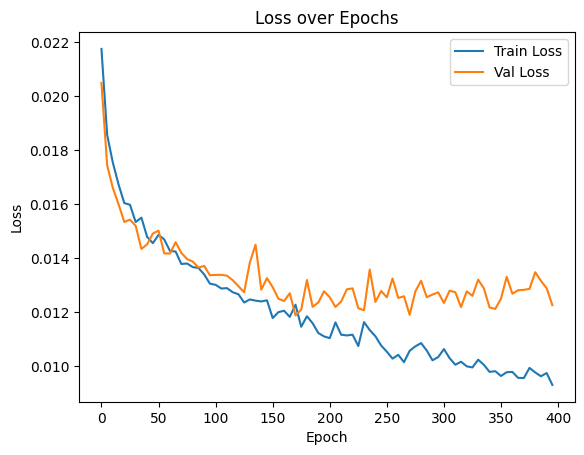

In [1809]:
train_loss_list=[]
for i in range(len(train_losses)):
    if i % 5 == 0:
        train_loss_list.append(train_losses[i])
        
val_loss_list=[]
for i in range(len(val_losses)):
    if i % 5 == 0:
        val_loss_list.append(val_losses[i])

epochs = [n * 5 for n in range(0, len(val_loss_list))]

plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [1810]:
print(model)

BioClassifier(
  (encoder): GraphEncoder(
    (rgcnconv1): RGCNConv(10, 512, num_relations=4)
    (rgcnconv2): RGCNConv(512, 256, num_relations=4)
    (rgcnconv3): RGCNConv(256, 128, num_relations=4)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [1811]:
# torch.save(model.state_dict(), 'models/rcgn_model_.pt')